__Purpose__ In this session we are going to take a single text (Pride and Prejudice) and perform topic modeling, extract the topics, and visualize hte topics over time - how the distribution of topics change over time with the intention of showing how it is possible to track how topics develop over the time of a novel

## Import libraries

In [39]:
# standard library
import sys,os
sys.path.append(os.path.join(".."))
from pprint import pprint

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# visualisation
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10

# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Read in text

In [40]:
filename = os.path.join("..", "data", "cenlab", "texts", "1813_Austen_Jane_PrideandPrejudice_Novel.txt")

In [41]:
with open(filename) as f:
    text = f.read()

__Split into individual sentences__

In [42]:
# We run the text through the spacy NLP object and split the text into sentences
doc = nlp(text)
sentences = [sent.string.strip() for sent in doc.sents]

In [43]:
# Inspecting the sentences object
sentences[:10]
# We have a list in which each entry is a sentence. 

['PRIDE AND PREJUDICE:',
 'A NOVEL.',
 'IN THREE VOLUMES.',
 'BY THE AUTHOR OF "SENSE AND SENSIBILITY."',
 'VOL.',
 'I.\n\n\nPRIDE & PREJUDICE.',
 'CHAPTER I.',
 'It is a truth universally acknowledged, that a single man in possession of a \ngood fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his first \nentering a neighbourhood, this truth is so well fixed in the minds of the \nsurrounding families, that he is considered as the rightful property of some \none or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that \nNetherfield Park is let at last?"']

In [44]:
len(sentences)
# There are 6752 sentences in the novel

6752

__Create chunks of 10 sentences at a time__

Instead of having individual sentences, we want to group them together into blocks of 10 sentences (app. a paragraph). If we just trained the topic model on individual sentences, we would end up with very unclear topics, which is why we group the sentences into groups of 10 sentences to make the topics more interpretable. This means that even when we have performed preprocessing (removed stopwords etc.) each chunk will still contain words. 

In [45]:
chunks = []
for index in range(0, len(sentences), 10):
    chunks.append(' '.join(sentences[index:index+10]))
# The for loop groups together 10 sentences at a time for whitespace

In [46]:
# We now have chunks of 10 sentences
chunks[:5]

['PRIDE AND PREJUDICE: A NOVEL. IN THREE VOLUMES. BY THE AUTHOR OF "SENSE AND SENSIBILITY." VOL. I.\n\n\nPRIDE & PREJUDICE. CHAPTER I. It is a truth universally acknowledged, that a single man in possession of a \ngood fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first \nentering a neighbourhood, this truth is so well fixed in the minds of the \nsurrounding families, that he is considered as the rightful property of some \none or other of their daughters. "My dear Mr. Bennet," said his lady to him one day, "have you heard that \nNetherfield Park is let at last?"',
 'Mr. Bennet replied that he had not. "But it is," returned she; "for Mrs. Long has just been here, and she told me \nall about it." Mr. Bennet made no answer. "Do not you want to know who has taken it?" cried his wife impatiently. "You want to tell me, and I have no objection to hearing it." This was invitation enough. "Why, my dear, you must know, Mrs. Long says 

In [47]:
len(chunks)
# We have 676 chunks of sentences

676

## Process using ```gensim```

Because we are not interested in individual words, we use  ```gensim``` to efficiently produce a model of bigrams and trigrams in the data. It creates a model of bigrams (a and b) above a certain count. The higher the threshold the fewer phrases we get, because it removes very frequent bigrams. If the score that gensim assigns to a phrase if above the threshold it is kept and if it is below it is filtered out. By doing this we only keep phrases that are semantically meaningful and not just noise. It also creates a model of trigrams. The model of trigrams is created from the model of bigrams + 1 word. 

We first create bigrams based on words appearing one after another frequently. These bigrams are then fed into a trigram generator, which takes the bigram as the second part of a bigram.

- bigram model = (a,b)
- trigram model = (x, (a,b))

In [48]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(chunks, min_count=3, threshold=100) # higher threshold fewer phrases. The min_count is the minimum number of times the bigram should occur to be included
trigram = gensim.models.Phrases(bigram[chunks], threshold=100) # the trigram model is based on the bigram model

# Fitting the models to the data
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Now we have taken the data and created a bigram and trigram model. Hence, we have reduced the data into bigrams and trigrams rather than individual tokens.

We can use the ```lda_utils.process_words()``` function to further process the data using ```spaCy```.
This function uses spacy to lemmatize and part-of-speech-tag each document.

Make sure to check the util script and see what arguments this function takes!

In [49]:
# Below we are processing each chunk of sentences. We are lemmatizing and performing part-of-speech tagging. The output therefore are the chunks but in a lemmatized form only including nouns.  
data_processed = lda_utils.process_words(chunks,
                                         nlp, 
                                         bigram_mod, 
                                         trigram_mod, 
                                         allowed_postags=["NOUN"]) # we only keep nouns as part-of-speech

In [63]:
# Inspecting what we have now
data_processed[:5]
# Now we basically just have a list of nouns. Each document has become much smaller than before, because it has been lemmatized and part-ofs-speech tagged

[['novel',
  'volume',
  'author',
  'sense',
  'chapter',
  'truth',
  'man',
  'possession',
  'fortune',
  'wife',
  'feeling',
  'view',
  'man',
  'neighbourhood',
  'truth',
  'mind',
  'family',
  'property',
  'daughter',
  'day'],
 ['answer',
  'want',
  'wife',
  'objection',
  'hearing',
  'invitation',
  'dear',
  'man',
  'place',
  'possession',
  'servant',
  'end',
  'week',
  'name'],
 ['man', 'fortune', 'year', 'thing', 'girl', 'wife', 'design'],
 ['design',
  'nonsense',
  'talk',
  'one',
  'occasion',
  'girl',
  'party',
  'dear',
  'beauty',
  'pretend',
  'thing',
  'woman',
  'daughter',
  'beauty',
  'case',
  'woman',
  'beauty',
  'dear',
  'neighbourhood'],
 ['assure',
  'daughter',
  'establishment',
  'account',
  'comer',
  'line',
  'consent',
  'marrying',
  'girl',
  'word',
  'other',
  'jane']]

__Create a bag of words__

We want to create a representation of words within a document - how often an indivudal word occurs in a document. Hence, we are conceptualizing our documents as a bag-of-words (there is no relation between the words)

We then need to create a ```gensim``` dictionary and a ```gensim``` corpus. Hence, we are no longer dealing with words, but instead each word is given an ID and each document is reduced to a distribution of word frequency. 

The dictionary converts each word into an integer value; the corpus creates a 'bag of words' model for all of the data - in this case, chunks of 10 sentences at a time.

In [50]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

In [66]:
# Inspecting what we now have: corpus = list of list of tuples
corpus[:5]
# Now instead of having a list of words, we now have a list of values. The first entry in the first tuple is the numerical ID of the word in question, and the second entry is how often that word appears in the documentt. 
# Each list in the list corresponds to a document
# We can see that every document in the corpus is now reduced to a distribution of words (numeric ID) and how many times that word occurs in the document
# NB! The word ID can correspond to a bigram or trigram and not just an individual word. This is of course only if bigrams and trigrams are actually present in the documents

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1)],
 [(7, 1),
  (11, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(6, 1), (7, 1), (17, 1), (29, 1), (30, 1), (31, 1), (32, 1)],
 [(2, 1),
  (9, 1),
  (19, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (33, 3),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2)],
 [(2, 1),
  (30, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1)]]

We then feed all of this information into our LDA algorithm using ```gensim```.

In [51]:
# Build LDA model
# We use gensim's multicore function which processes in parallel which is faster
lda_model = gensim.models.LdaMulticore(corpus=corpus,    # vectorized corpus (list of lists of tuples)
                                       id2word=id2word,  # gensim dictionary (mapping words to IDs)
                                       num_topics=10,    # number of topics
                                       random_state=100, # set a random state for reproducibility
                                       chunksize=10,     # the number of chunks we want to process at a time. Hence, rather than processing one chunk at a time, we process batches of 10 chunkes which is more efficient. Increasing the chunk/batch size means that the model will train quicker.  
                                       passes=10,        # passes/epochs is the number of times we want to go through the entire corpus. Passes is how often we go over the full corpus.
                                       iterations=100,   # Iterations is how often we go through the single document in the corpus
                                       per_word_topics=True, # defining word distributions for greater interpretatbility
                                       minimum_probability=0.0) # minimum value - in some cases a topic does not appear at all in any document, and we do not want to exclude these topics but keep them which is why we set it to return 0 instead of nothing which is the default

In [67]:
type(lda_model)

gensim.models.ldamulticore.LdaMulticore

We now have our trained LDA model. We can then calculate model perplexity and coherence in order to interpret how well the model performs. When we are calculating perplexity we measure how well the model is performing - how much it is surprised every time it encounters new things. We want surprisal (error) to be low, because this implies that when it encounters new data, it is less surprised. Hence, we want to minimize perplexity. We want coherence to be high - high coherence means that the topics are very coherent, which means that the topics actually correspond/relate to something in the data. 

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.341183221406798

Coherence Score:  0.32293011815227307


Lastly, we can inspect the 'contents' of the model

In [53]:
pprint(lda_model.print_topics())

[(0,
  '0.021*"time" + 0.013*"door" + 0.013*"mother" + 0.013*"sister" + '
  '0.013*"family" + 0.012*"thing" + 0.011*"thought" + 0.010*"day" + '
  '0.010*"part" + 0.009*"smile"'),
 (1,
  '0.050*"letter" + 0.022*"care" + 0.019*"person" + 0.014*"term" + '
  '0.014*"scheme" + 0.012*"curiosity" + 0.012*"state" + 0.011*"opinion" + '
  '0.010*"time" + 0.010*"sense"'),
 (2,
  '0.023*"society" + 0.019*"event" + 0.016*"congratulation" + 0.015*"change" + '
  '0.014*"attention" + 0.014*"disappointment" + 0.013*"misery" + '
  '0.012*"distress" + 0.012*"desire" + 0.011*"profession"'),
 (3,
  '0.028*"sister" + 0.020*"direction" + 0.019*"feeling" + 0.016*"derbyshire" + '
  '0.016*"consent" + 0.016*"relief" + 0.015*"gardiner" + 0.014*"temper" + '
  '0.014*"wish" + 0.014*"situation"'),
 (4,
  '0.024*"manner" + 0.016*"way" + 0.015*"year" + 0.015*"darcy" + '
  '0.015*"brother" + 0.014*"mind" + 0.013*"acquaintance" + '
  '0.013*"satisfaction" + 0.012*"question" + 0.011*"astonishment"'),
 (5,
  '0.024*"sist

Above we can see that we have 10 topics. 

Problems with the model:
- A lot of repeated words across topics

We probably want to perform further preprocessing and exclude some words, or maybe we want to restructure our model. 

## Run model multiple times to find best fit

We compute coherence values. We can look at the point in which the coherence value is the highest, and this is the optimal number of topics. 

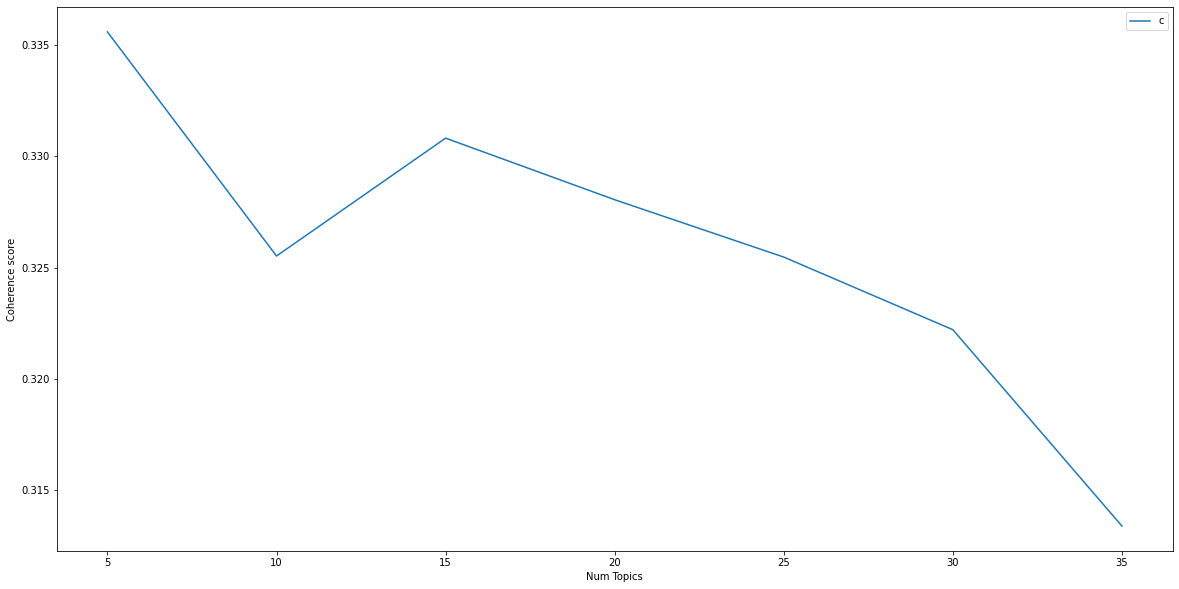

Num Topics = 5  has Coherence Value of 0.3356
Num Topics = 10  has Coherence Value of 0.3255
Num Topics = 15  has Coherence Value of 0.3308
Num Topics = 20  has Coherence Value of 0.3281
Num Topics = 25  has Coherence Value of 0.3255
Num Topics = 30  has Coherence Value of 0.3222
Num Topics = 35  has Coherence Value of 0.3134


In [54]:
# Can take a long time to run.
model_list, coherence_values = lda_utils.compute_coherence_values(texts=data_processed,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=5, 
                                                                  limit=40,  
                                                                  step=5)

## Create dataframe showing most dominant topic per chunk

We take the LDA_model, the courpus, and the preprocessed data and bundle them up. 

In [69]:
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Chunk_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Chunk_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.7869,"manner, way, year, darcy, brother, mind, acquaintance, satisfaction, question, astonishment","[novel, volume, author, sense, chapter, truth, man, possession, fortune, wife, feeling, view, ma..."
1,1,5.0,0.6517,"sister, day, time, mother, thing, room, friend, family, morning, attention","[answer, want, wife, objection, hearing, invitation, dear, man, place, possession, servant, end,..."
2,2,4.0,0.6006,"manner, way, year, darcy, brother, mind, acquaintance, satisfaction, question, astonishment","[man, fortune, year, thing, girl, wife, design]"
3,3,0.0,0.9550,"time, door, mother, sister, family, thing, thought, day, part, smile","[design, nonsense, talk, one, occasion, girl, party, dear, beauty, pretend, thing, woman, daught..."
4,4,3.0,0.9308,"sister, direction, feeling, derbyshire, consent, relief, gardiner, temper, wish, situation","[assure, daughter, establishment, account, comer, line, consent, marrying, girl, word, other, jane]"
5,5,6.0,0.9470,"moment, letter, man, hope, friend, thing, sister, darcy, place, room","[preference, none, recommend, girl, sister, abuse, child, way, delight, compassion, nerve, respe..."
6,6,3.0,0.7587,"sister, direction, feeling, derbyshire, consent, relief, gardiner, temper, wish, situation","[hope, man, year, neighbourhood, visit, visit, mixture, part, reserve, caprice, experience, year..."
7,7,5.0,0.9500,"sister, day, time, mother, thing, room, friend, family, morning, attention","[business, life, daughter, news, chapter, visit, wife, evening, visit, knowledge, manner, daught..."
8,8,1.0,0.9307,"letter, care, person, term, scheme, curiosity, state, opinion, time, sense","[niece, woman, opinion, reply, contain, daughter, compassion, nerve, tear, piece, cough, amusement]"
9,9,5.0,0.9437,"sister, day, time, mother, thing, room, friend, family, morning, attention","[mother, day, introduce, dear, friend, teazing, honour, circumspection, fortnight, acquaintance,..."


In [56]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9795,"time, door, mother, sister, family, thing, thought, day, part, smile","[hate, friend, father, scruple, head, hunsford, dear, father, uneasiness, misfortune, breach, ti..."
1,1.0,0.9791,"letter, care, person, term, scheme, curiosity, state, opinion, time, sense","[meeting, time, pay, respect, trust, excuse, ignorance, connection, apology, pardon, yesterday, ..."
2,2.0,0.9823,"society, event, congratulation, change, attention, disappointment, misery, distress, desire, pro...","[case, fact, absence, friend, town, business, imagine, business, part, intelligence, absence, fe..."
3,3.0,0.9727,"sister, direction, feeling, derbyshire, consent, relief, gardiner, temper, wish, situation","[sex, doubt, possibility, woman, capacity, taste, application, elegance, injustice, doubt, woman..."
4,4.0,0.9750,"manner, way, year, darcy, brother, mind, acquaintance, satisfaction, question, astonishment","[moment, salutation, return, minute, leave, friend, lady, bow, entreaty, throwing, window, invit..."
5,5.0,0.9857,"sister, day, time, mother, thing, room, friend, family, morning, attention","[property, estate, year, daughter, heir, mother, fortune, situation, life, supply, deficiency, a..."
6,6.0,0.9786,"moment, letter, man, hope, friend, thing, sister, darcy, place, room","[case, circumstance, case, friend, change, resolution, moment, person, desire, proceed, arrange,..."
7,7.0,0.9727,"servant, anxiety, thought, object, face, impertinence, interest, share, vexation, point","[summon, dinner, girl, object, dining, room, furniture, commendation, thing, heart, supposition,..."
8,8.0,0.9654,"rosing, room, trouble, alarm, love, parsonage, addition, arrangement, road, sister","[admiration, brilliancy, exercise, complexion, doubt, occasion, thinking, breakfast, enquiry, si..."
9,9.0,0.9667,"marriage, darcy, family, daughter, place, thing, man, woman, money, husband","[illustration, character, shake, gravity, success, head, account, report, respect, character, re..."


^Here we have the 10 topics and for each topic we can see how frequenly it occurs across the corpus (e.g. topic 2 occurs in 98% of the chunks in some way). We can also see the keywords for the topics. The representative text is not very interpretable, because it is lemmatized. 

## Visualise topics

Using pyLDAvis we can explore the corpus in more detail. We can look at the different topics. 

In [57]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.142843 -0.058837       1        1  25.837885
6     -0.107055 -0.046217       2        1  14.877140
0     -0.057842 -0.073134       3        1  14.659743
9     -0.138352  0.048143       4        1  10.345579
4     -0.017851  0.213226       5        1   8.349088
1      0.129089  0.073796       6        1   6.878996
2      0.050998 -0.063838       7        1   5.665243
3      0.015935  0.070817       8        1   5.389221
8      0.079516 -0.150390       9        1   5.217167
7      0.188404 -0.013568      10        1   2.779938, topic_info=          Term        Freq       Total Category  logprob  loglift
659     letter  116.000000  116.000000  Default  30.0000  30.0000
357   marriage   74.000000   74.000000  Default  29.0000  29.0000
119       room  131.000000  131.000000  Default  28.0000  28.0000
63      sister  224.000000  224.000000  Default  27.0000  27.0000
405    thought   53.000000   53.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
202        eye    3.200323   54.993203  Topic10  -4.9409   0.7388
163  attention    3.251735   78.619020  Topic10  -4.9250   0.3973
466     dining    2.335928   13.026463  Topic10  -5.2557   1.8642
38       party    2.498520   40.625550  Topic10  -5.1884   0.7940
81        life    2.313533   45.641287  Topic10  -5.2654   0.6007

[587 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1354      5  0.927397  abhorrence
1827     10  0.841785  abruptness
833       4  0.116616     absence
833       5  0.583079     absence
833       7  0.174924     absence
...     ...       ...         ...
32        4  0.095416        year
32        5  0.333957        year
32        6  0.143124        year
32        8  0.047708        year
1054      6  0.904233       youth

[1047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 10, 5, 2, 3, 4, 9, 8])

NB! The topic numbers are based on the percentage contribution, which means that topic 1 does not correspond to topic 1 we saw previously. 

## To dataframe 

In [58]:
values = list(lda_model.get_document_topics(corpus))
# The first entry it the topic, and the second entry is how much it contributes (percentage)

__Split tuples and keep only values per topic__

In [59]:
split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

__Create document-topic matrix__

In [60]:
df = pd.DataFrame(map(list,zip(*split)))

In [61]:
df

,0,1,2,3,4,5,6,7,8,9,...,666,667,668,669,670,671,672,673,674,675
0,0.004764,0.006668,0.012504,0.954986,0.007695,0.005885,0.005001,0.005557,0.007696,0.006253,...,0.003449,0.131057,0.005264,0.003705,0.002501,0.002084,0.003847,0.165116,0.120965,0.016669
1,0.004763,0.006668,0.012502,0.005001,0.007694,0.005885,0.005001,0.005557,0.930741,0.006252,...,0.298255,0.007693,0.124602,0.003705,0.002501,0.026191,0.003847,0.080230,0.102146,0.486443
2,0.004763,0.006668,0.012501,0.005001,0.007694,0.005883,0.005001,0.005557,0.007694,0.006252,...,0.003449,0.086611,0.233014,0.046506,0.161007,0.302147,0.071277,0.077032,0.002174,0.016667
3,0.004764,0.006667,0.012502,0.005001,0.930752,0.005885,0.758757,0.005557,0.007696,0.006252,...,0.003449,0.007694,0.005264,0.137946,0.102335,0.149644,0.003847,0.094433,0.002174,0.380218
4,0.786990,0.006669,0.600509,0.005002,0.007694,0.005885,0.201234,0.005559,0.007696,0.006254,...,0.049457,0.007693,0.088507,0.046304,0.002500,0.002084,0.117783,0.181286,0.484303,0.016667
5,0.004764,0.651655,0.012503,0.005002,0.007694,0.005886,0.005001,0.949984,0.007695,0.943728,...,0.365584,0.007694,0.405649,0.003705,0.190448,0.349382,0.091004,0.002001,0.052278,0.016667
6,0.004763,0.255424,0.299472,0.005002,0.007694,0.947039,0.005001,0.005557,0.007695,0.006253,...,0.266010,0.728477,0.005264,0.531980,0.039879,0.002084,0.297911,0.002001,0.078935,0.016667
7,0.004763,0.046244,0.012501,0.005001,0.007694,0.005883,0.005001,0.005557,0.007694,0.006252,...,0.003449,0.007693,0.005264,0.003704,0.002500,0.002084,0.003846,0.002000,0.002174,0.016667
8,0.004763,0.006668,0.012502,0.005003,0.007694,0.005883,0.005001,0.005557,0.007695,0.006252,...,0.003449,0.007694,0.005264,0.165442,0.002500,0.027866,0.003847,0.023180,0.075798,0.016667
9,0.174903,0.006669,0.012504,0.005002,0.007694,0.005886,0.005001,0.005558,0.007699,0.006253,...,0.003449,0.007693,0.121908,0.057003,0.493828,0.136436,0.402792,0.372721,0.079053,0.016667


^Each row corresponds to a topic. Each column correspond to a chunk. Hence, we now have all chunks (675) for each topic represented in a dataframe.

## Plot with seaborn

We use the rolling mean to calculate rolling scores. If we did not compute the rolling mean, the data would just be very noisy. When we take a rolling mean of 50, we take batches of chunks at a time, and look at how the chunks change over time (over the novel). 

<AxesSubplot:>

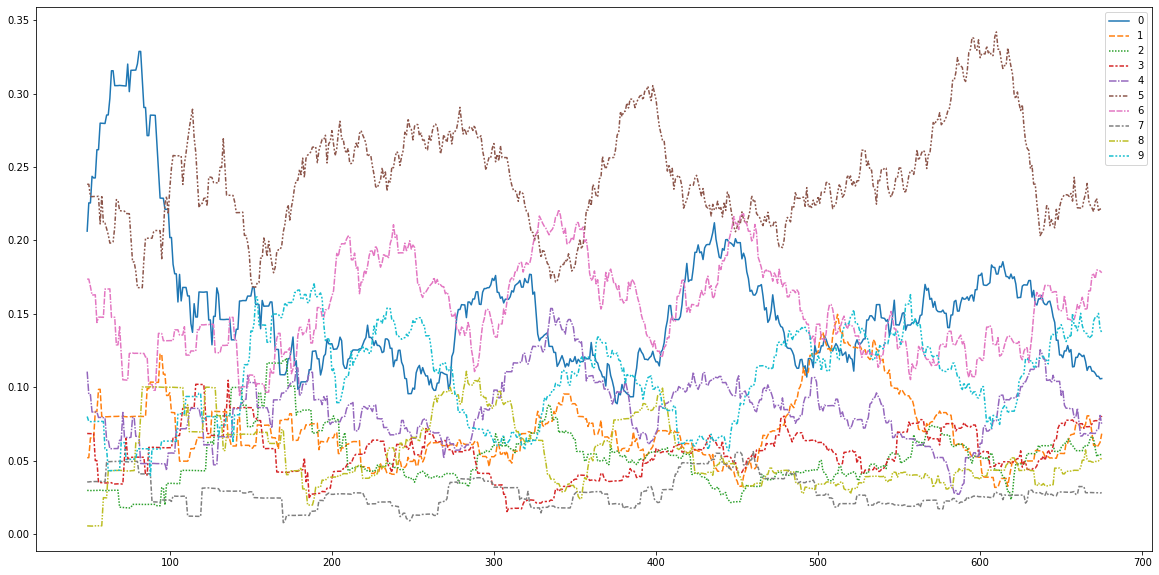

In [62]:
sns.lineplot(data=df.T.rolling(50).mean())

This is still very noisy, but we can see that in the beginning topic 0 is the most prominent topic (it takes up the most percentage of the text), but at the end of the novel, it is topic 5 that is most dominant. Hence, over time topic 5 becomes more prominent, and this topic has to do with heirs, estates, marriage, fortunes etc. 

__Conclusion__ <br> 
We have gone from a novel (a textual object) and we have shown how topic distributions change over the course of the novel through topic modeling. Hence, we have used topic modeling to track the use of topics across a novel. In this case, topic modeling is very useful, because the topics are easy to interpret, which allows us to go beyond just clustering topics together. 